# Instruction

- Download datasets from links below and run commented code in **Data** section, that will prepare folder with images.
- Fold everything for better understanding

# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Imports

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms, datasets
from torchvision import models
from torch.utils.data.sampler import WeightedRandomSampler


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skimage.morphology import skeletonize
from itertools import product

import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import cv2
import time
import shutil

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Params and Helpers

In [71]:
class Params:
    MAX_LEN = 12
    vocab = " abcdefghijklmnopqrstuvwxyz" # 1-indexed
    char_to_index = {char: i for i, char in enumerate(vocab)}
    index_to_char = {i: char for i, char in enumerate(vocab)}

    @staticmethod
    def encode_string(s: str):
        return [Params.char_to_index[char] for char in s]

    @staticmethod
    def decode_string(encoded: list[int]):
        return ''.join([Params.index_to_char[i] for i in encoded if i != 0])

In [72]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None
        self.early_stop = False
    
    def __call__(self, val_loss: float, model: nn.Module):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [73]:
def sample_loader(loader: DataLoader, procent: float):
    dataset = loader.dataset
    indices = torch.randperm(len(dataset))[:int(len(dataset) * procent)]
    dataset = torch.utils.data.Subset(dataset, indices)

    return DataLoader(
        dataset, batch_size=loader.batch_size, num_workers=4, shuffle=True
    )

# Data

In [74]:
# # Get list of images and labels
# with open('iam_words/words.txt', 'r') as f:
#     words = f.readlines()
# words = [word.strip() for word in words]
# words = words[18:-1]
# words = [w for w in words if ' err ' not in w]
# words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
# words = [
#     [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
# df = pd.DataFrame(words, columns=['filename', 'word'])
# df = df[df['filename'].apply(os.path.exists)]



# # Filter out invalid images
# valid_rows = []
# for i, (path, label) in df.iterrows():
#     try:
#         with Image.open(path) as img:
#             img.verify()  # Verify that the file is a valid image
#         valid_rows.append((path, label))
#     except Exception as e:
#         print(f"Skipping file {path} due to error: {e}")
#     if i % (len(df) //100 + 1) == 0:
#         print('.', end='')
# print('\n')

# df = pd.DataFrame(valid_rows, columns=df.columns)
# df = df[df['word'].apply(lambda x: all(char in Params.vocab[1:]
#                          for char in x) and len(x) <= Params.MAX_LEN)]



# # Split data into sets convinient for torch dataset
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)
# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)



# # Save images in convinient for torch way
# shutil.rmtree('words_data', ignore_errors=True)

# for i, (im, label) in train_df.iterrows():
#     new_path = f'words_data/train/{label.ljust(Params.MAX_LEN, "_")}'
#     if not os.path.exists(new_path):
#         os.makedirs(new_path)
#     im = Image.open(im)
#     im.save(f'{new_path}/{i}.png')
#     if i % (len(train_df) // 100 + 1) == 0:
#         print('.', end='')
# print()

# for i, (im, label) in val_df.iterrows():
#     new_path = f'words_data/val/{label.ljust(Params.MAX_LEN, "_")}'
#     if not os.path.exists(new_path):
#         os.makedirs(new_path)
#     im = Image.open(im)
#     im.save(f'{new_path}/{i}.png')
#     if i % (len(val_df) // 100 + 1) == 0:
#         print('.', end='')
# print()


# for i, (im, label) in test_df.iterrows():
#     new_path = f'words_data/test/{label.ljust(Params.MAX_LEN, "_")}'
#     if not os.path.exists(new_path):
#         os.makedirs(new_path)
#     im = Image.open(im)
#     im.save(f'{new_path}/{i}.png')
#     if i % (len(test_df) // 100 + 1) == 0:
#         print('.', end='')

# Dataset

In [75]:
class HandWritingDataset(datasets.ImageFolder):
    def __init__(
        self,
        root,
        transform: transforms.Compose = None,
        label_transofrm=None,
        augument: transforms.Compose = None
    ):
        if augument is not None:
            transform = transforms.Compose([
                augument,
                transform
            ])

        super(HandWritingDataset, self).__init__(root, transform=transform)
        self.classes = [''.join([i if i != '_' else ' ' for i in word]) for word in self.classes]
        self.label_transform = label_transofrm


    def __getitem__(self, index):
        image, label = super(HandWritingDataset, self).__getitem__(index)
        if self.label_transform is not None:
            label = tensor(self.label_transform(self.classes[label]))

        return image, label

# DataLoader

### transformations

In [76]:
augument = transforms.Compose([
    transforms.RandomRotation(15, expand=True, fill=(255,)),
    transforms.RandomAffine(0, translate=(0.1, 0.1), fill=(255,)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255,)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

transform = transforms.Compose([
    transforms.Resize((32, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,)),
])

### datasets

In [77]:
train_dataset = HandWritingDataset(
    root='words_data/train',
    transform=transform,
    label_transofrm=Params.encode_string,
    augument=augument
)

val_dataset = HandWritingDataset(
    root='words_data/val',
    transform=transform,
    label_transofrm=Params.encode_string
)

test_dataset = HandWritingDataset(
    root='words_data/test',
    transform=transform,
    label_transofrm=Params.encode_string
)

### sampler

In [78]:
# Count weights of word frequency for potential ballancing dataset
class_counts = np.bincount([label for _, label in train_dataset.samples])
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset.samples]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

### loaders

In [79]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True,
    # sampler=sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=4,
    shuffle=True
)

### images

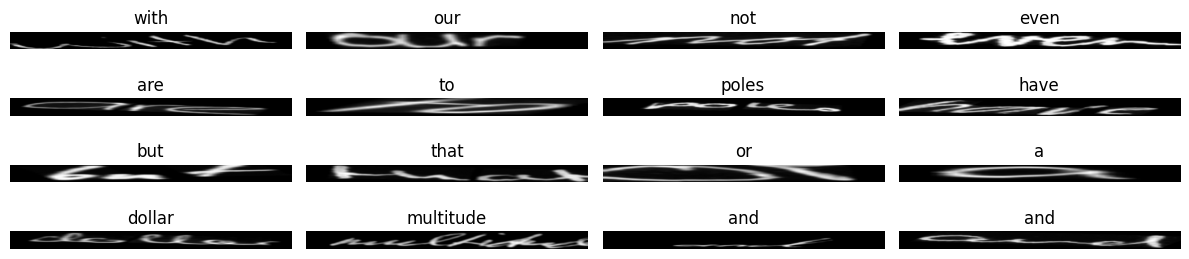

In [80]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Plot 16 images
fig, axes = plt.subplots(4, 4, figsize=(12, 3))
for i, ax in enumerate(axes.flatten()):
    if i >= len(images):
        break
    ax.imshow(images[i][0].cpu(), cmap='gray')  # Assuming grayscale images
    ax.set_title(Params.decode_string(labels[i].tolist()))
    ax.axis('off')
plt.tight_layout()
plt.show()

# Train test predict

### test

In [81]:
def test(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):
    model.eval()
    all_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            batch_size = images.size(0)
            input_lengths = torch.full(
                size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)
            target_lengths = torch.tensor(
                [len(seq[seq != 0]) for seq in labels], dtype=torch.long).to(device)

            all_loss += criterion(outputs, labels, input_lengths, target_lengths)

    loss = all_loss / len(dataloader)

    return loss

### train

In [82]:
def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, epochs: int, early_stopping: EarlyStopping = None):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        progress_bar = -1
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            batch_size = images.size(0)
            input_lengths = torch.full(
                size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)
            target_lengths = torch.tensor(
                [len(seq[seq != 0]) for seq in labels], dtype=torch.long).to(device)
            
            loss = criterion(outputs, labels, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Print progress bar
            new_progress_bar = i * 100 // len(train_loader)
            if new_progress_bar > progress_bar:
                for j in range(new_progress_bar - progress_bar):
                    print('=', end='', flush=True)
                progress_bar = new_progress_bar

        # Print epoch summary
        val_loss = test(model, val_loader, criterion)
        train_loss /= len(train_loader)
        print(f"\nEpoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping and restore best model
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                model.load_state_dict(early_stopping.best_model)
                break

### predict

In [83]:
def predict(model: nn.Module, dataloader: DataLoader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).squeeze(1)
            labels = labels.squeeze(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend([Params.decode_string(preds.cpu().numpy())])
            all_labels.extend([Params.decode_string(labels.cpu().numpy())])
    return list(zip(all_preds, all_labels))

# Model

In [84]:
class TLModel(nn.Module):
    def __init__(self,):
        super(TLModel, self).__init__()
        self.mnv2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2).features[:-1]
        self.set_trainable(False)
        self.lstm = nn.LSTM(input_size=320, hidden_size=256, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.5)
        self.dense = nn.Linear(512, 27)

    def forward(self, x):
        x = self.mnv2(x)

        x = x.permute(0, 3, 2, 1)
        x = x.flatten(2)

        x, _ = self.lstm(x)

        x = self.dense(x)
        x = x.permute(1, 0, 2)
        x = F.log_softmax(x, dim=2)
        
        return x
    
    def set_trainable(self, trainable: bool):
        for param in self.mnv2.parameters():
            param.requires_grad = trainable 

# Training

In [85]:
model = TLModel().to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
early_stopping = EarlyStopping(patience=10)

# to_train_loader = train_loader
# to_val_loader = val_loader

to_train_loader = sample_loader(train_loader, 0.02)
to_val_loader = sample_loader(val_loader, 0.1)

In [86]:
train(model, to_train_loader, to_val_loader, optimizer, criterion, epochs=1, early_stopping=early_stopping)

Epoch 1/1, Train Loss: 12.5570, Val Loss: 12.3342


In [87]:
model.set_trainable(True)
early_stopping = EarlyStopping(patience=10)

In [88]:
train(model, to_train_loader, to_val_loader, optimizer, criterion, epochs=1, early_stopping=early_stopping)

Epoch 1/1, Train Loss: 11.4906, Val Loss: 8.0391


In [89]:
os.makedirs('models', exist_ok=True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, f"models/model_{timestamp}.pth")
model = torch.load(f"models/model_{timestamp}.pth", weights_only=False)
_ = model.eval()

In [90]:
show_loader = sample_loader(test_loader, 0.01)

predict(model, show_loader)

[('', 'happen'),
 ('', 'they'),
 ('', 'may'),
 ('', 'of'),
 ('', 'strikes'),
 ('', 'make'),
 ('', 'thirty'),
 ('', 'wait'),
 ('', 'which'),
 ('', 'high'),
 ('', 'the'),
 ('', 'unto'),
 ('eeeeee', 'ephemeral'),
 ('', 'example'),
 ('', 'was'),
 ('', 'was'),
 ('', 'made'),
 ('', 'by'),
 ('', 'inspiring'),
 ('', 'to'),
 ('', 'for'),
 ('', 'of'),
 ('', 'unaligned'),
 ('', 'been'),
 ('', 'country'),
 ('', 'panel'),
 ('qqqqqqt', 'created'),
 ('', 'netting')]